# Notebook: Create Corpus Analysis 

This notebook is used to create plots using our trained model.
<br>**Contributors:** [Nils Hellwig](https://github.com/NilsHellwig/) | [Markus Bink](https://github.com/MarkusBink/)

## Packages

In [1]:
from plots_mb import plot_overall_sentiment, plot_sentiment, plot_sentiment_line_graph_for_each_month, plot_sentiment_line_graph_for_each_month_6_week, plot_overall_opposition_government_sentiment
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import random
import os

## Parameters

In [2]:
PLOTS_PATH = "../Plots/"
PARTIES = ["SPD", "CDU_CSU", "GRUENE", "FDP", "AFD", "LINKE"]
DATASET_PATH_PREDICTIONS =  "../Datasets/complete_dataset_predictions/"
DATASET_PATH = "../Datasets/dataset/"

## Code

### Load Data

In [3]:
df = pd.DataFrame({})

for party in PARTIES:
    for subdir, _, files in os.walk(DATASET_PATH_PREDICTIONS + party):
        for file in files:
            if file.endswith('.csv') and subdir[len(DATASET_PATH_PREDICTIONS):] in PARTIES:
                # Get username of CSV file
                username = file[:-4]
                
                # Read CSV file as pandas dataframe
                df_acc_data = pd.read_csv(DATASET_PATH + party + "/" + file)
                ids = df_acc_data["id"].values
                df_acc_data = df_acc_data[["source_party", "date"]].reset_index().drop(columns='index')
                
                df_pred = pd.read_csv(DATASET_PATH_PREDICTIONS + party + "/" + file)
                df_pred = df_pred[df_pred["id"].isin(ids)][["pred"]].reset_index().drop(columns='index')
                
                matched_df = pd.concat([df_acc_data, df_pred], axis=1)
                matched_df['pred'] = matched_df['pred'].replace({0: 1, 1: -1, 2: 0})
                matched_df = matched_df.rename(columns={'pred': 'sentiment_value', 'source_party': "party"})
                matched_df["sentiment"] = matched_df["sentiment_value"]
                matched_df['sentiment'] = matched_df['sentiment'].replace({0: "Neutral", -1: "Negative", 1: "Positive"})
                matched_df['date'] = pd.to_datetime(matched_df['date']).dt.date
                
                df = pd.concat([df, matched_df], axis=0)

df = df.reset_index().drop(columns='index')

In [4]:
df

,party,date,sentiment_value,sentiment
0,SPD,2021-01-09,1,Positive
1,SPD,2021-01-09,1,Positive
2,SPD,2021-01-09,1,Positive
3,SPD,2021-01-09,-1,Negative
4,SPD,2021-01-09,1,Positive
...,...,...,...,...
707236,LINKE,2021-12-17,-1,Negative
707237,LINKE,2021-12-17,-1,Negative
707238,LINKE,2021-12-17,1,Positive
707239,LINKE,2021-12-17,0,Neutral


In [5]:
df["party"] = df["party"].replace({"CDU_CSU": "CDU/CSU", "GRUENE": "Grüne", "AFD": "AfD", "LINKE": "Die Linke"})

### Create Figure with Bar Charts for Overall Sentiment Distribution

In [6]:
general_count = df['sentiment'].value_counts().tolist()
government_count = df[df['party'].isin(["SPD", "CDU/CSU"])]['sentiment'].value_counts().tolist()
opposition_count = df[~df['party'].isin(["SPD", "CDU/CSU"])]['sentiment'].value_counts().tolist()

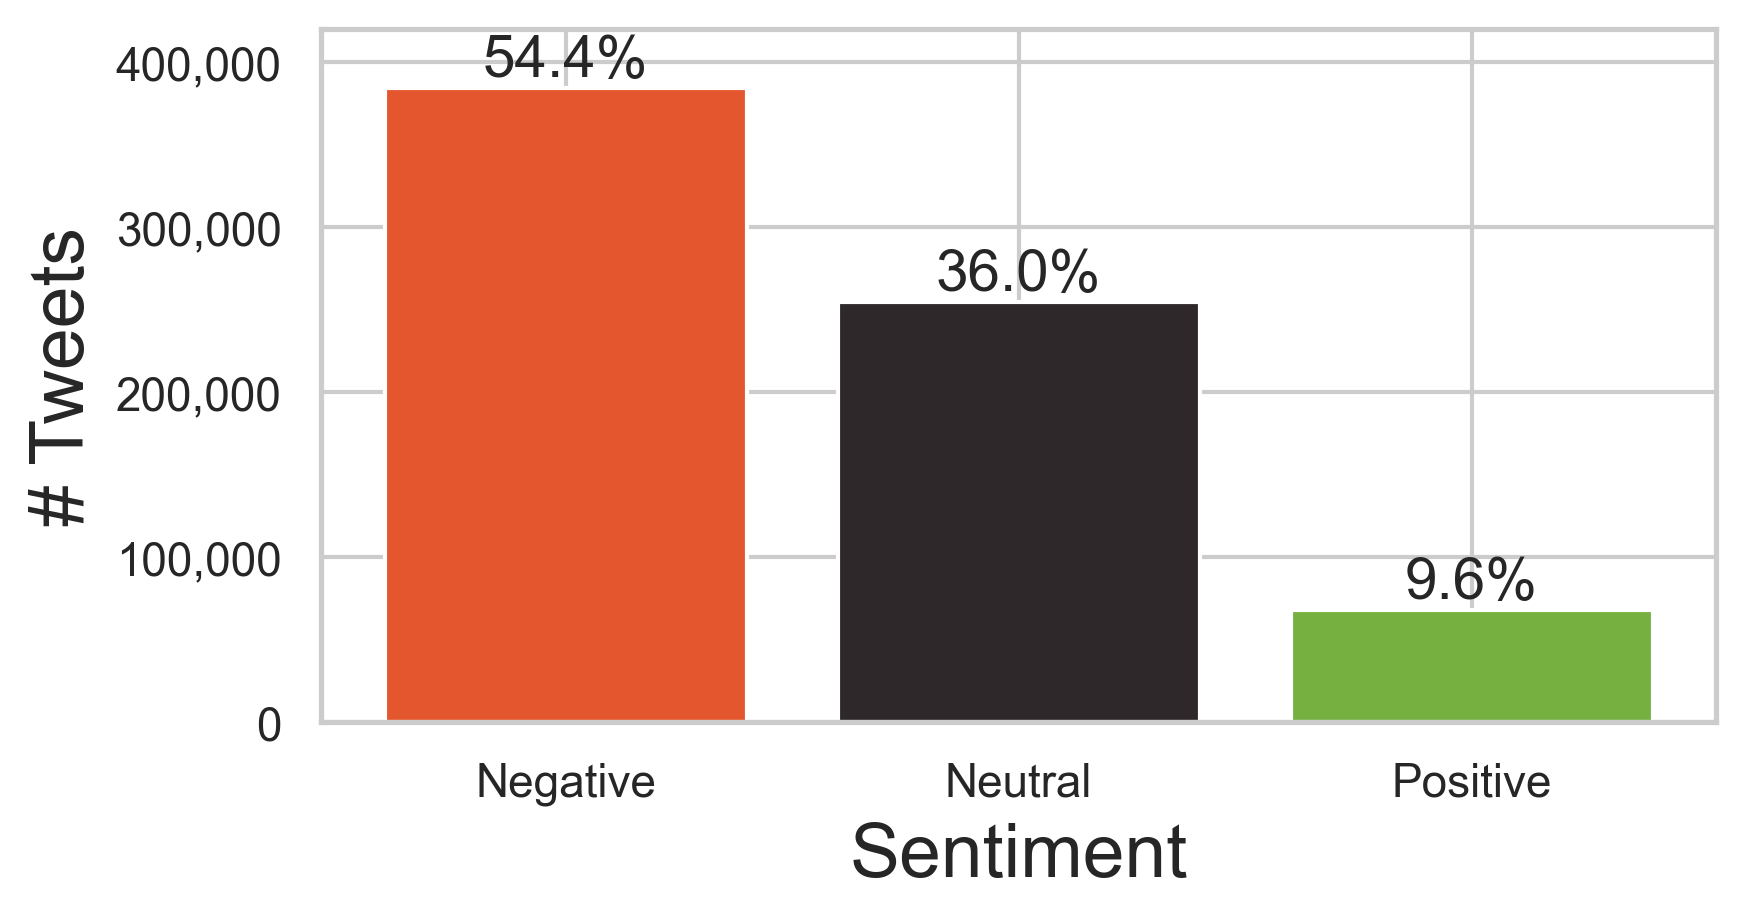

In [7]:
filename = PLOTS_PATH + "overall_sentiment"
plot_overall_sentiment(general_count, filename, len_dataset=len(df))

### Create Figure with Bar Charts for Sentiment Distribution: General, Government and Opposition

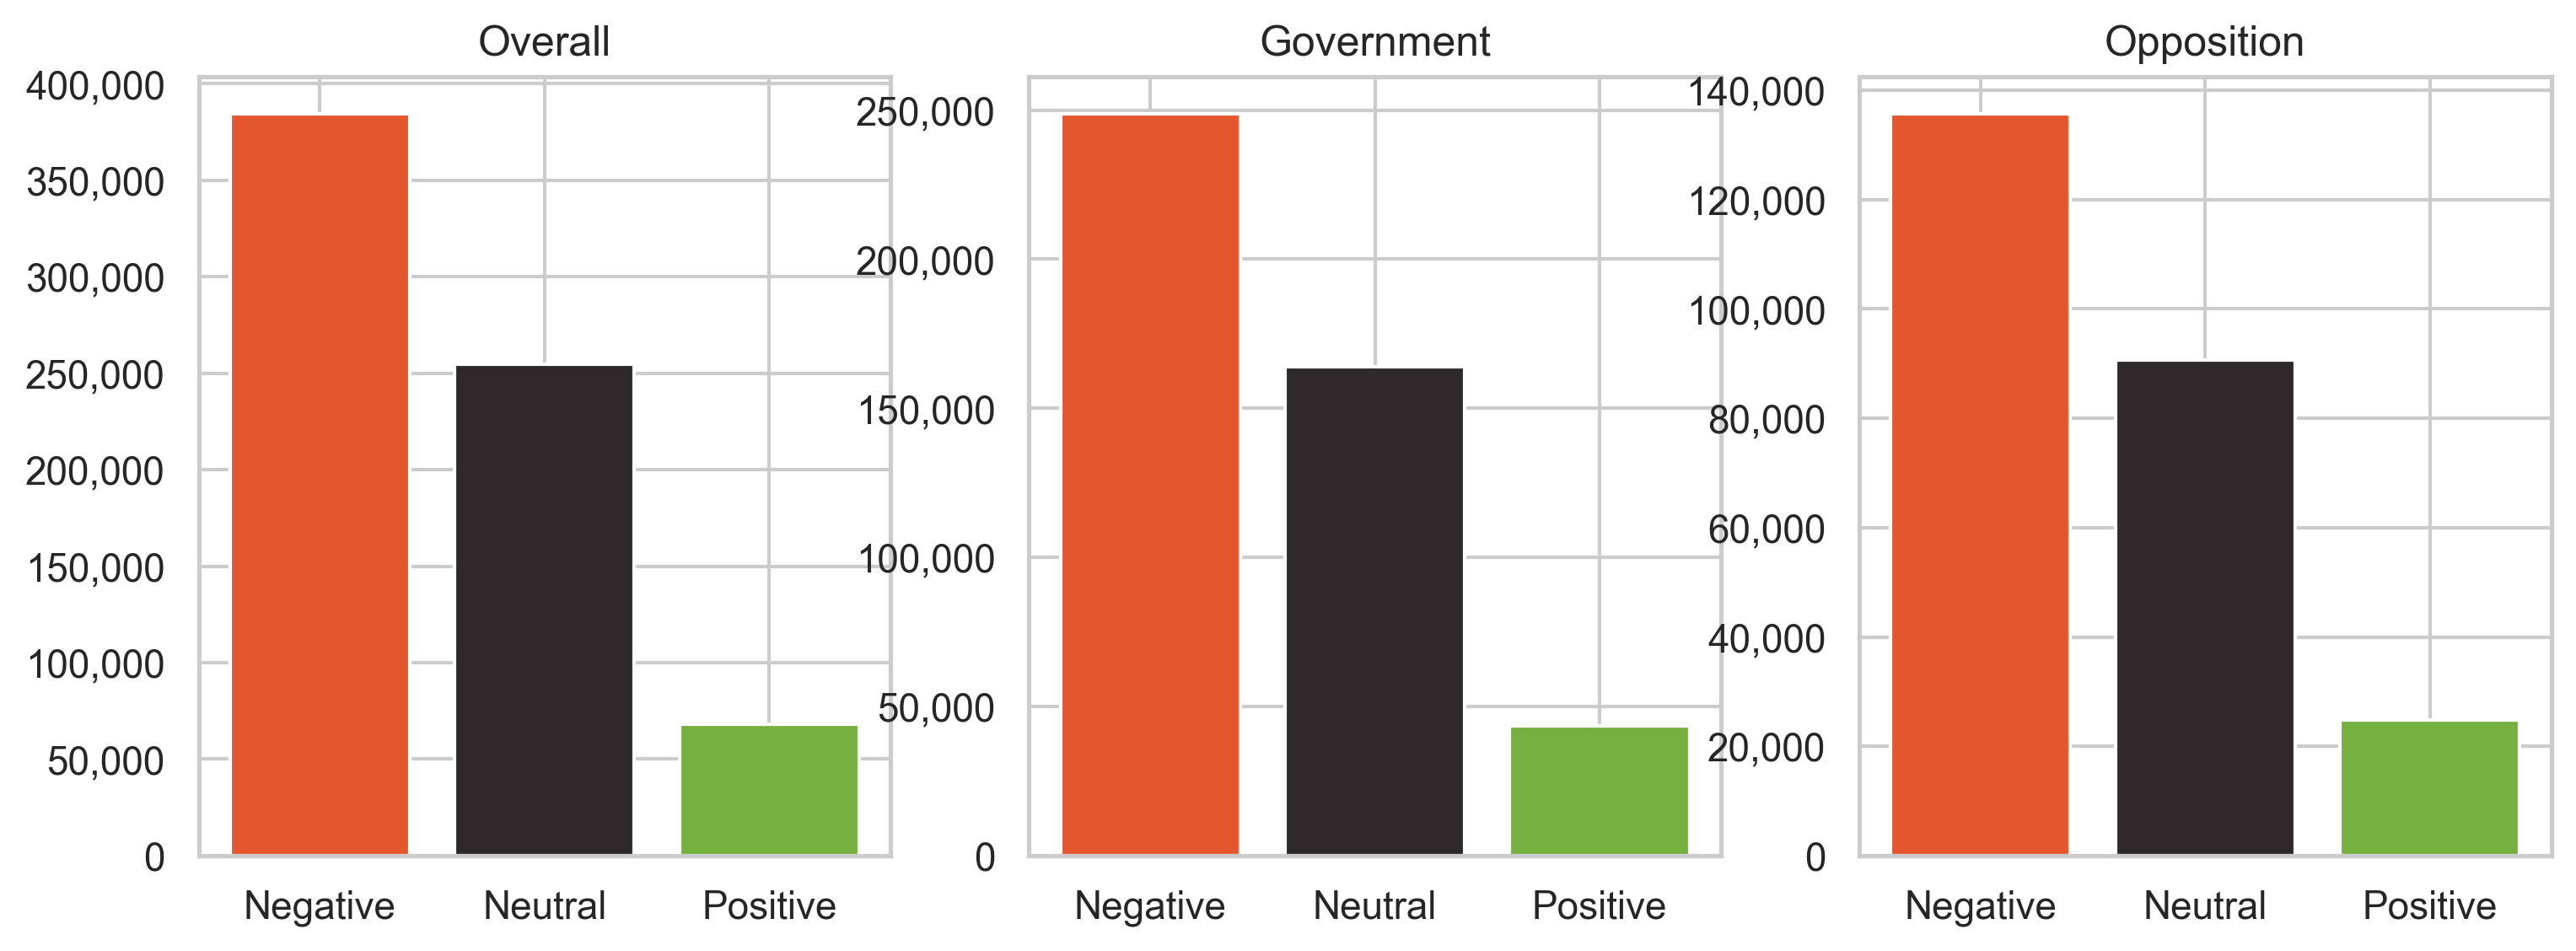

In [8]:
filename = PLOTS_PATH + "sentiment_general_government_opposition"
plot_overall_opposition_government_sentiment(general_count, government_count, opposition_count, filename)

### Create Figure for Percentage Distribution of Sentiment Classes

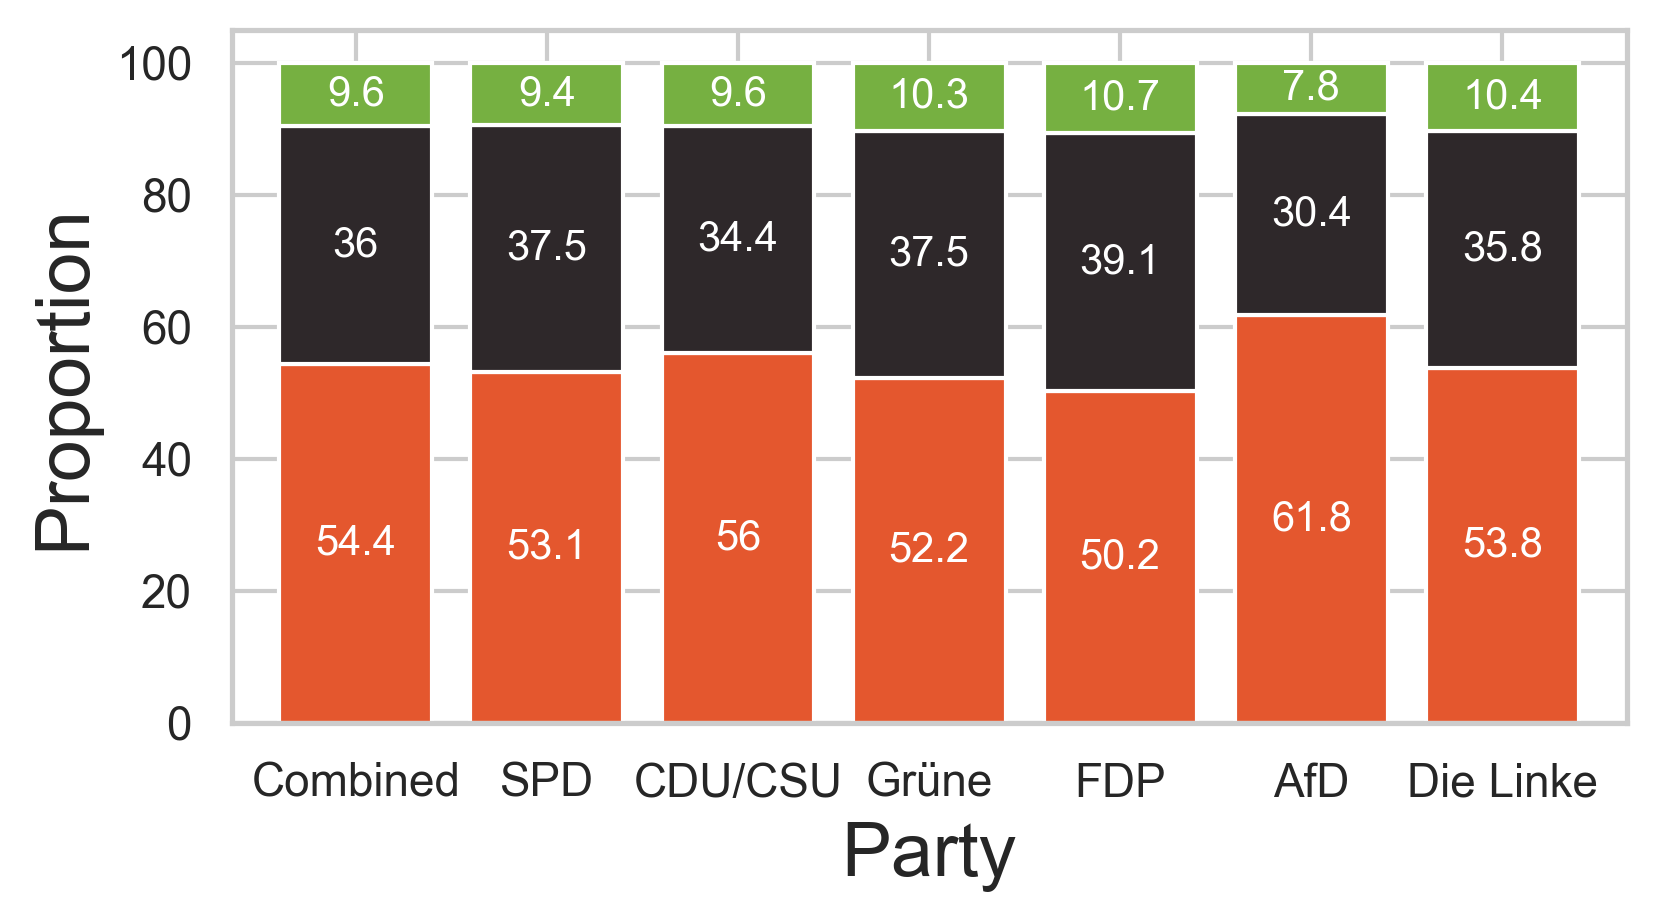

In [9]:
filename = PLOTS_PATH + "proportion_sentiment_parties"
plot_sentiment(df, filename)

### Mean Sentiment per month for the political parties over the whole election year

In [10]:
df['month'] = pd.DatetimeIndex(df['date']).month
month_sentiment_df = df.pivot_table(index=['party', 'month'], values='sentiment_value', aggfunc='mean').reset_index()

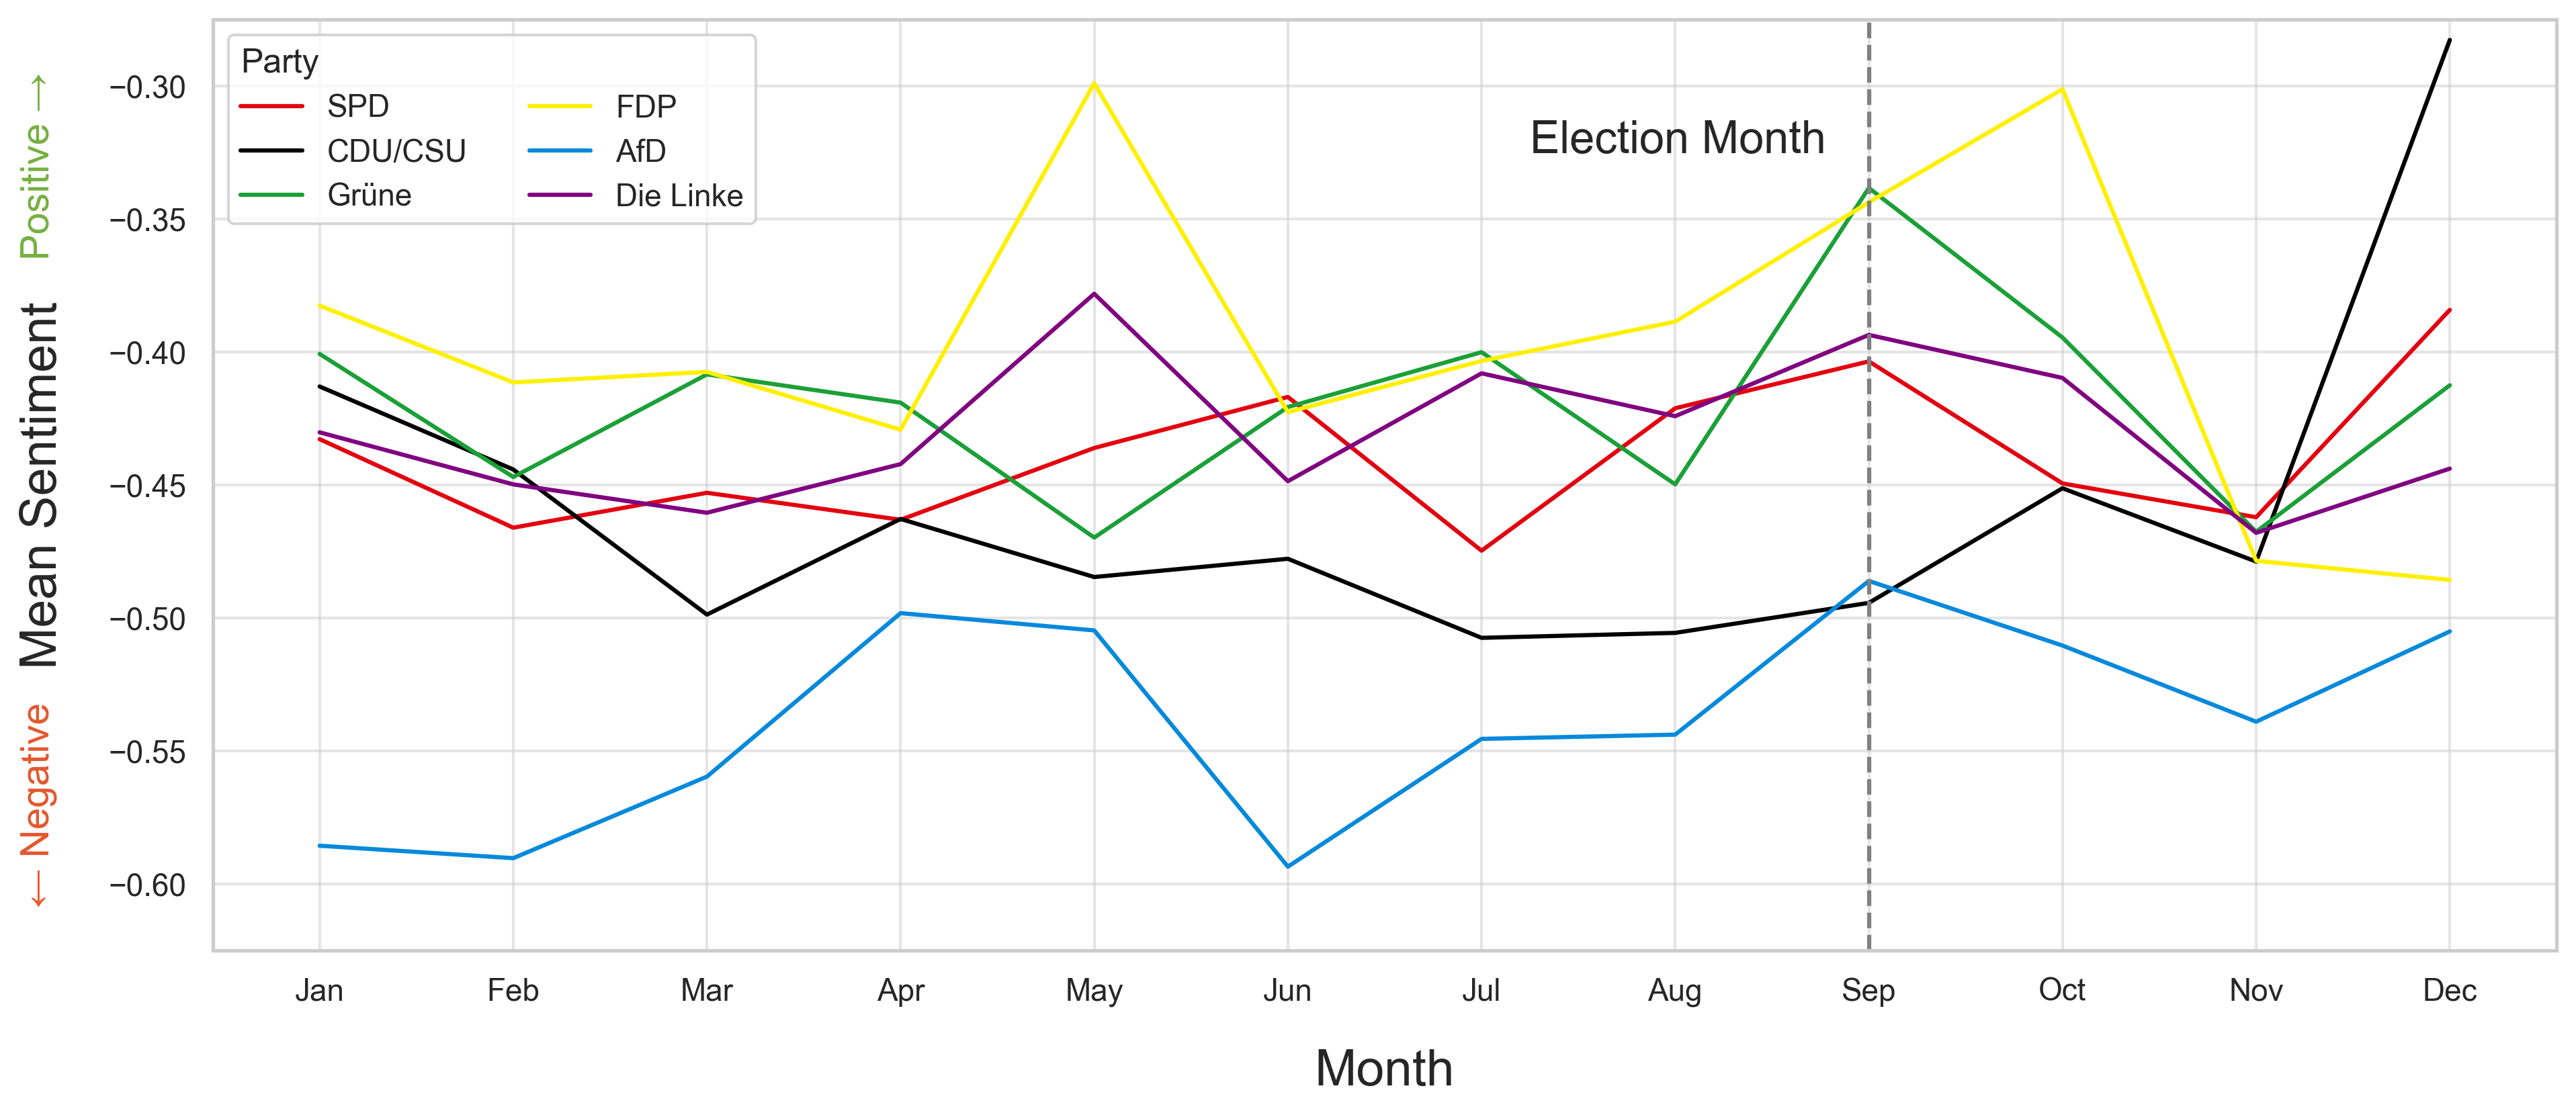

In [11]:
filename = PLOTS_PATH + "mean_sentiment_parties_months"
plot_sentiment_line_graph_for_each_month(month_sentiment_df, filename)

### Create Figure for Percentage Distribution of Sentiment Classes (6-week period before and after the election)

In [12]:
weeks_election_df = df.copy()
weeks_election_df['date'] = pd.to_datetime(weeks_election_df['date'])
weeks_election_df = weeks_election_df[weeks_election_df['date'].between('2021-08-15', '2021-11-06')]
weeks_election_df['week'] = (weeks_election_df['date'] + pd.DateOffset(days=-6)).dt.isocalendar().week
weeks_election_df['first_day_week'] = weeks_election_df['week'].apply(lambda x: datetime.strptime(f'2021-W{x+1}-0', '%Y-W%U-%w').strftime('%Y-%m-%d'))
weeks_election_df = weeks_election_df.pivot_table(index=['party', 'week', 'first_day_week'], values='sentiment_value', aggfunc='mean').reset_index()

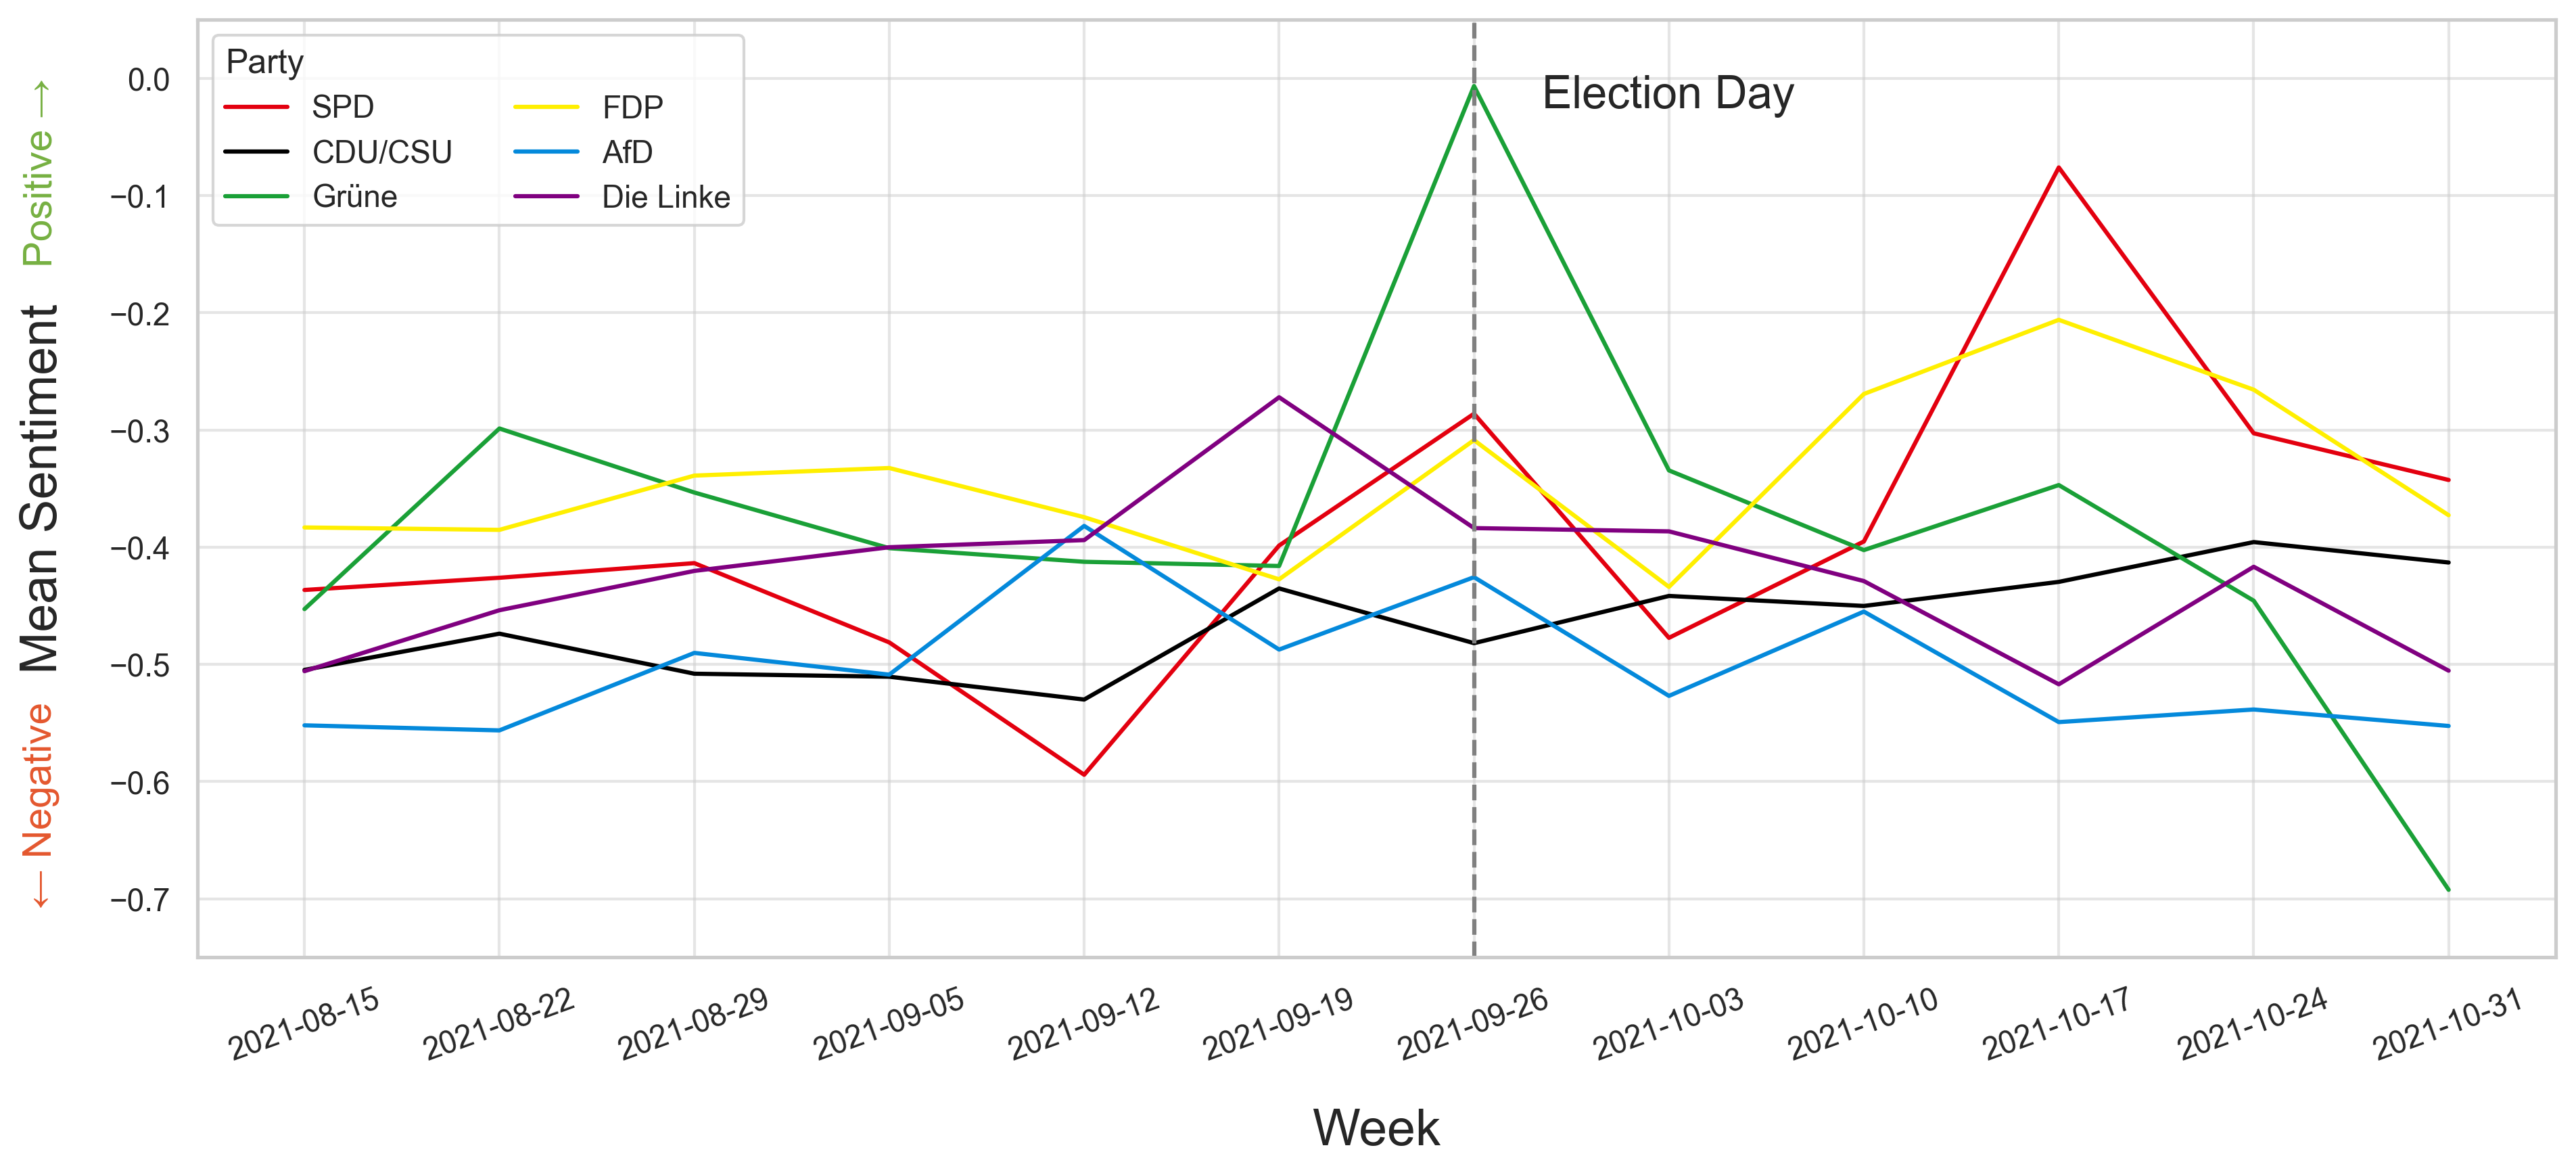

In [13]:
filename = PLOTS_PATH + "mean_sentiment_parties_6_weeks"
plot_sentiment_line_graph_for_each_month_6_week(weeks_election_df, filename)